## Deep Learning
Assignment 2
Previously in 1_notmnist.ipynb, we created a pickle with formatted datasets for training, development and testing on the notMNIST dataset.
The goal of this assignment is to progressively train deeper and more accurate models using TensorFlow.

In [5]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
from time import time
import math
%matplotlib inline

# First reload the data we generated in 1_notmnist.ipynb.
pickle_file = 'proj1/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions,1) == np.argmax(labels,1))
            / predictions.shape[0])

image_size = 28
num_labels = 10

# Reformat into a shape that's more adapted to the models we're going to train:
# - data as a flat matrix,
# - labels as float 1-hot encodings.
def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (8933, 28, 28) (8933,)
Test set (8639, 28, 28) (8639,)
Training set (200000, 784) (200000, 10)
Validation set (8933, 784) (8933, 10)
Test set (8639, 784) (8639, 10)


In [6]:
import matplotlib.pyplot as plt

def indexed_color(i):
    colormap = plt.cm.Set1
    x = (i % 9) * 0.99 / 8.0
    return colormap(x)

def plot_accuracy(accuracy):
    _ , ax = plt.subplots(nrows=1, ncols=1)
    ymax = accuracy[0,:]
    ymin = accuracy[1,:]
    ax.set_xlabel("epochs")
    ax.set_ylabel("accuracy")
    color1 = indexed_color(1)
    color2 = indexed_color(2)
    color3 = indexed_color(14)
    
    epochs = np.arange(accuracy.shape[1])
    ax.plot(epochs, ymax, color=color3)
    ax.plot(epochs, ymin, color=color2)
    ax.fill_between(epochs, ymin, ymax, facecolor=color3, alpha=0.25).set_edgecolor(color3)

# run training on a list of configurations, each repeated n times
# validation accuracie stored in an array of shape=(number_of_replicates, number_of_epochs)



## We're first going to train a multinomial logistic regression using simple gradient descent.
TensorFlow works like this:
- First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:
 - with graph.as_default():
    ...
- Then you can run the operations on this graph as many times as you want by calling session.run(), providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:
 - with tf.Session(graph=graph) as session:
    ...
Let's load all the data into TensorFlow and build the computation graph corresponding to our training:

In [7]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
# LR , no regulation, no dropout, no SGD
train_subset = 10000

graph = tf.Graph()

with graph.as_default():
    
    # input data.
    # Load the training, validation and test data into constants that are
    # attached to the graph
    
    tf_train_dataset = tf.constant(train_dataset[:train_subset,:])
    tf_train_labels  = tf.constant(train_labels[:train_subset])
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    # These are the parameters that we are going to be training. The weight
    # matrix will be initialized using random values following a (truncated)
    # normal distribution. The biases get initialized to zero.
    
    weights = tf.Variable(
       tf.truncated_normal([image_size * image_size, num_labels],
                stddev= math.sqrt(2.0/ (image_size * image_size))))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    # We multiply the inputs with the weight matrix, and add biases. We compute
    # the softmax and cross-entropy (it's one operation in TensorFlow, because
    # it's very common, and it can be optimized). We take the average of this
    # cross-entropy across all training examples: that's our loss.
    
    logits = tf.matmul(tf_train_dataset, weights) + biases # 10000*784, 784*10
    loss = tf.reduce_mean(
       tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    # Optimizer.
    # We are going to find the minimum of this loss using gradient descent.
    Optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for training, validation, and test data.
    # These are not part of training, but merely here so that we can report
    # accuracy figures as we train.
    
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
      tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

# Let's run this computation and iterate
num_steps = 801
accuracy_epoch = np.zeros([2,num_steps])
with tf.Session(graph=graph) as session:
    # This is a one-time operation which ensures the parameters get initialized
    # as we described in the graph: random weights for the matrix, zeros for the
    # biases.
    tf.initialize_all_variables().run()
    loss_step = np.zeros(num_steps)
    print('Initialized')
    for step in range(num_steps):
        # Run the computations. We tell .run() that we want to run the optimization
        # and get the loss value and the training predictions returned as numpy arrays.
        _, l, predictions = session.run([Optimizer, loss, train_prediction])
        accuracy_epoch[0,step] = accuracy(valid_prediction.eval(), valid_labels)
        accuracy_epoch[1,step] = accuracy(test_prediction.eval(), test_labels)
        if (step % 100 ==0):
            print('Loss at step %d: %f' % (step, l))
            print('Training accuracy: %.1f%%' % accuracy(predictions, train_labels[:train_subset,:]))
            # Calling .eval() on validation_prediction is basically like calling run(), but
            # just to get that one numpy array. Note that it recomputes all its graph
            # dependencies.
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
            
            
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
    session.close()

Initialized
Loss at step 0: 2.289893
Training accuracy: 16.0%
Validation accuracy: 61.9%
Loss at step 100: 0.620543
Training accuracy: 84.0%
Validation accuracy: 81.0%
Loss at step 200: 0.580957
Training accuracy: 84.9%
Validation accuracy: 81.1%
Loss at step 300: 0.558158
Training accuracy: 85.7%
Validation accuracy: 81.0%
Loss at step 400: 0.541844
Training accuracy: 86.1%
Validation accuracy: 80.8%
Loss at step 500: 0.529005
Training accuracy: 86.5%
Validation accuracy: 80.7%
Loss at step 600: 0.518350
Training accuracy: 86.7%
Validation accuracy: 80.6%
Loss at step 700: 0.509206
Training accuracy: 86.9%
Validation accuracy: 80.4%
Loss at step 800: 0.501173
Training accuracy: 87.2%
Validation accuracy: 80.3%
Test accuracy: 87.3%


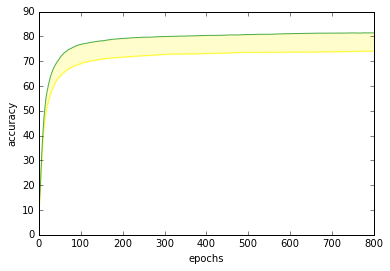

In [7]:
plot_accuracy(accuracy_epoch)  

## Let's now switch to stochastic gradient descent training instead, which is much faster.
The graph will be similar, except that instead of holding all the training data into a constant node, we create a Placeholder node which will be fed actual data at every call of session.run().

In [8]:
# LR, with SGD, no regularization, no dropout
batch_size = 128
LR = 0.5
graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that 
    # will be fed at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    weights = tf.Variable(
       tf.truncated_normal([image_size * image_size, num_labels],
                           stddev= math.sqrt(2.0/ (image_size * image_size))))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
       tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(LR).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
          tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

num_steps = 3001
accuracy_epoch = np.zeros([2,num_steps])
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0]-batch_size)
        
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset+batch_size),:]
        batch_labels = train_labels[offset:(offset+batch_size),:]
        
        # Prepare a dictionary telling the session where to feed the 
        # minibatch. The key of the dictionary is the placeholder node of the
        # graph to be fed and the value is the numpy array.
        
        feed_dict = {tf_train_dataset : batch_data, 
                     tf_train_labels : batch_labels}
        _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        accuracy_epoch[0,step] = accuracy(valid_prediction.eval(), valid_labels)
        accuracy_epoch[1,step] = accuracy(test_prediction.eval(), test_labels)


        if (step % 1000 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
        
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    session.close()



Initialized
Minibatch loss at step 0: 2.384893
Minibatch accuracy: 7.0%
Validation accuracy: 45.2%
Minibatch loss at step 1000: 0.699626
Minibatch accuracy: 80.5%
Validation accuracy: 81.1%
Minibatch loss at step 2000: 0.531953
Minibatch accuracy: 89.8%
Validation accuracy: 81.0%
Minibatch loss at step 3000: 0.652689
Minibatch accuracy: 85.9%
Validation accuracy: 81.3%
Test accuracy: 88.3%


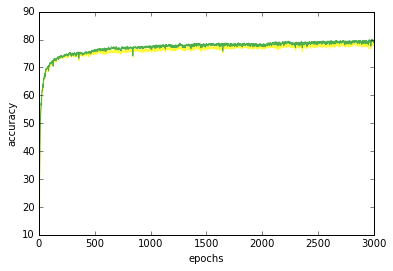

In [199]:
plot_accuracy(accuracy_epoch)  
#accuracy_epoch.shape

## Problem
Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units nn.relu() and 1024 hidden nodes. This model should improve your validation / test accuracy.


In [9]:
# NN, 1024 nodes
batch_size = 128
num_nodes = 1024
LR = 0.5
graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that 
    # will be fed at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    weights1 = tf.Variable(
       tf.truncated_normal([image_size * image_size, num_nodes],
                           stddev= math.sqrt(2.0/ (image_size * image_size))))
    biases1 = tf.Variable(tf.zeros([num_nodes]))
    weights2 = tf.Variable(
       tf.truncated_normal([num_nodes, num_labels],
                           stddev= math.sqrt(2.0/ num_nodes)))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    logits1 = tf.matmul(tf_train_dataset, weights1) + biases1
    tf_hidden_dataset = tf.nn.relu(logits1)
    logits = tf.matmul(tf_hidden_dataset, weights2) + biases2
    
    loss = tf.reduce_mean(
       tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(LR).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    
    first_valid = tf.matmul(tf_valid_dataset, weights1) + biases1
    logits_valid = tf.matmul(tf.nn.relu(first_valid), weights2) + biases2
    valid_prediction = tf.nn.softmax(logits_valid)
    
    first_test = tf.matmul(tf_test_dataset, weights1) + biases1
    logits_test = tf.matmul(tf.nn.relu(first_test), weights2) + biases2
    test_prediction = tf.nn.softmax(logits_test)

num_steps = 3000
accuracy_epoch = np.zeros([2,num_steps])
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0]-batch_size)
        
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset+batch_size),:]
        batch_labels = train_labels[offset:(offset+batch_size),:]
        
        # Prepare a dictionary telling the session where to feed the 
        # minibatch. The key of the dictionary is the placeholder node of the
        # graph to be fed and the value is the numpy array.
        
        feed_dict = {tf_train_dataset : batch_data, 
                     tf_train_labels : batch_labels}
        _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
        accuracy_epoch[0,step] = accuracy(valid_prediction.eval(), valid_labels)
        accuracy_epoch[1,step] = accuracy(test_prediction.eval(), test_labels)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    session.close()

Initialized
Minibatch loss at step 0: 2.340827
Minibatch accuracy: 7.8%
Validation accuracy: 32.6%
Minibatch loss at step 500: 0.355731
Minibatch accuracy: 90.6%
Validation accuracy: 85.1%
Minibatch loss at step 1000: 0.538590
Minibatch accuracy: 85.2%
Validation accuracy: 85.7%
Minibatch loss at step 1500: 0.288260
Minibatch accuracy: 93.0%
Validation accuracy: 86.7%
Minibatch loss at step 2000: 0.272758
Minibatch accuracy: 93.8%
Validation accuracy: 86.7%
Minibatch loss at step 2500: 0.323889
Minibatch accuracy: 89.1%
Validation accuracy: 87.4%
Test accuracy: 93.7%


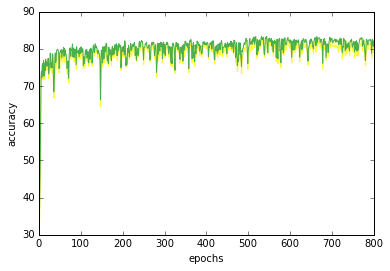

In [186]:
plot_accuracy(accuracy_epoch)  

In [11]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn import preprocessing  
import random 
import math

LR=0.5
#trainSubset=10000;
epochsCount=3001
batchSize=128

file = open('proj1/notMNIST_original.pickle','rb')
data=pickle.load(file);
file.close()


classesCount= len(np.unique(data['train_labels']))
print('classesCount is : ', classesCount)
trainShape= data['train_dataset'].shape
validCount= data['valid_dataset'].shape[0]
testCount= data['test_dataset'].shape[0]
trainCount= trainShape[0]
featuresCount= trainShape[1]*trainShape[2]

X_train=data['train_dataset'].reshape((-1, featuresCount)).astype(np.float32);
y_train=preprocessing.label_binarize(data['train_labels'],range(0, classesCount))
X_valid=data['valid_dataset'].reshape((-1, featuresCount)).astype(np.float32);
y_valid= preprocessing.label_binarize(data['valid_labels'],range(0, classesCount))
X_test=data['test_dataset'].reshape((-1, featuresCount)).astype(np.float32);
y_test= preprocessing.label_binarize(data['test_labels'],range(0, classesCount))

#X_train= X_train[0:trainSubset,:]
#y_train= y_train[0:trainSubset,:]

X= tf.placeholder(tf.float32,[None,featuresCount])
y= tf.placeholder(tf.float32,[None,classesCount])

W= tf.Variable(tf.truncated_normal([featuresCount,classesCount], stddev= math.sqrt(2.0/ featuresCount)))
b= tf.Variable(tf.zeros([1,classesCount]))
#global_step = tf.Variable(0) 
#learning_rate = tf.train.exponential_decay(
#          0.7,                      # Base learning rate.
#          global_step,   # Current index into the dataset.
#          trainCount,                # Decay step.
#          0.95,                      # Decay rate.
#          staircase=True)
f=tf.matmul(X,W)+b;
F=tf.nn.softmax(f);

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(f,y)) ;
optimizer = tf.train.GradientDescentOptimizer(LR).minimize(cost);

session = tf.Session()
session.run(tf.initialize_all_variables())                                                                                                                                                                      

for i in range(epochsCount):
    offset =(i * batchSize) % (trainCount - batchSize)
    batchX = X_train[offset:(offset + batchSize), :]
    batchY = y_train[offset:(offset + batchSize), :]
    # feed_dict allows the caller to override the values of tensors in the graph          
    session.run(optimizer, feed_dict={X: batchX, y: batchY})
    #print(learning_rate)    

binarizer= preprocessing.LabelBinarizer()
binarizer.fit(range(0,10))

# Evaluate the tensor `F`.
preds = session.run(F, feed_dict={X:X_test});
print(preds.shape)
testAccuarcy= (binarizer.inverse_transform(preds)==binarizer.inverse_transform(y_test)).mean() * 100
session.close()
print("Test Accuracy: ", testAccuarcy, "\n")

classesCount is :  10
(10000, 10)
Test Accuracy:  89.14 

